In [ ]:
#12/06/25
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.YY0YHL_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.YY0YHL_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [ ]:
nombres_clases = metadatos.features['label'].names

In [ ]:
# Normalizar los datos (pasar de 0-255 a 0-1)
def normalizar (imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

# Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

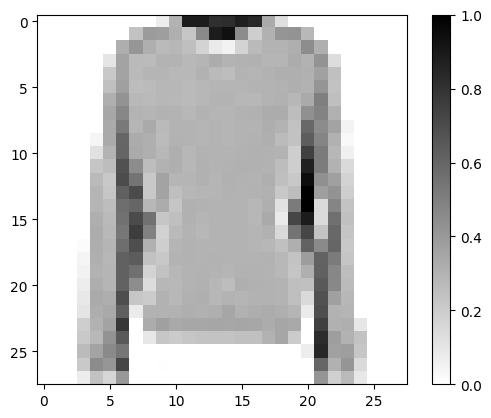

In [ ]:
# Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

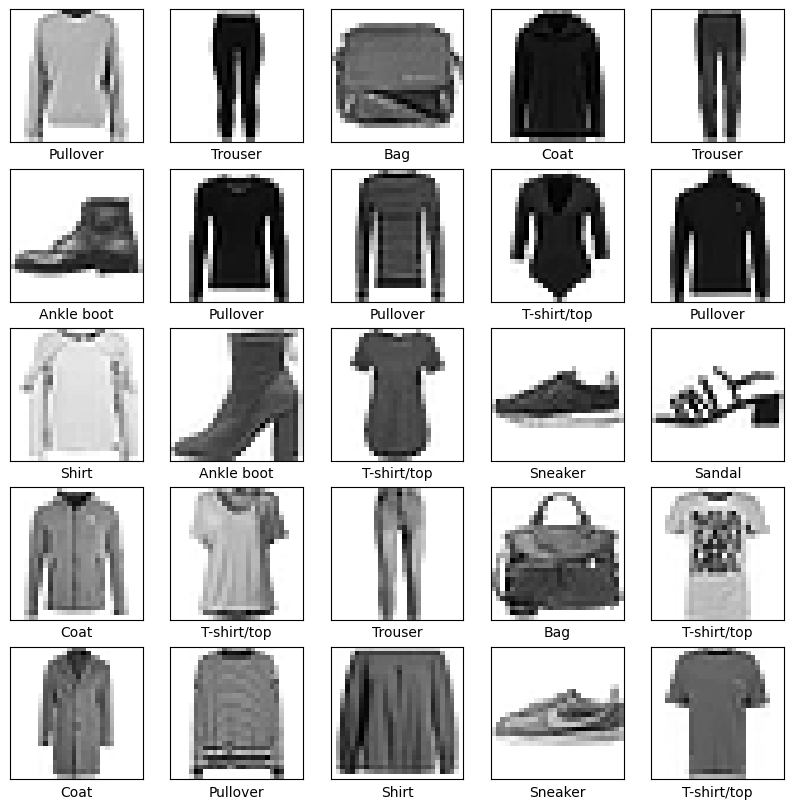

In [ ]:
plt.figure(figsize=(10,10))
for i , (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [ ]:
# Crear el modelo

modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Para redes de clasificacion
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compilar el modelo

modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [ ]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [ ]:
TAMANO_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
#13/06/25
import math
# Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7582 - loss: 0.7037
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8604 - loss: 0.3849
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8721 - loss: 0.3544
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8812 - loss: 0.3290
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8837 - loss: 0.3126


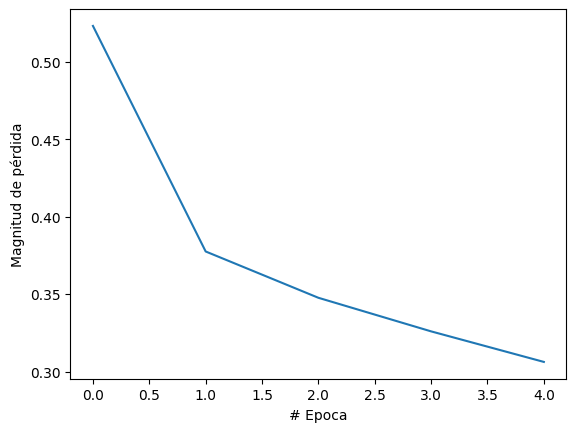

In [ ]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


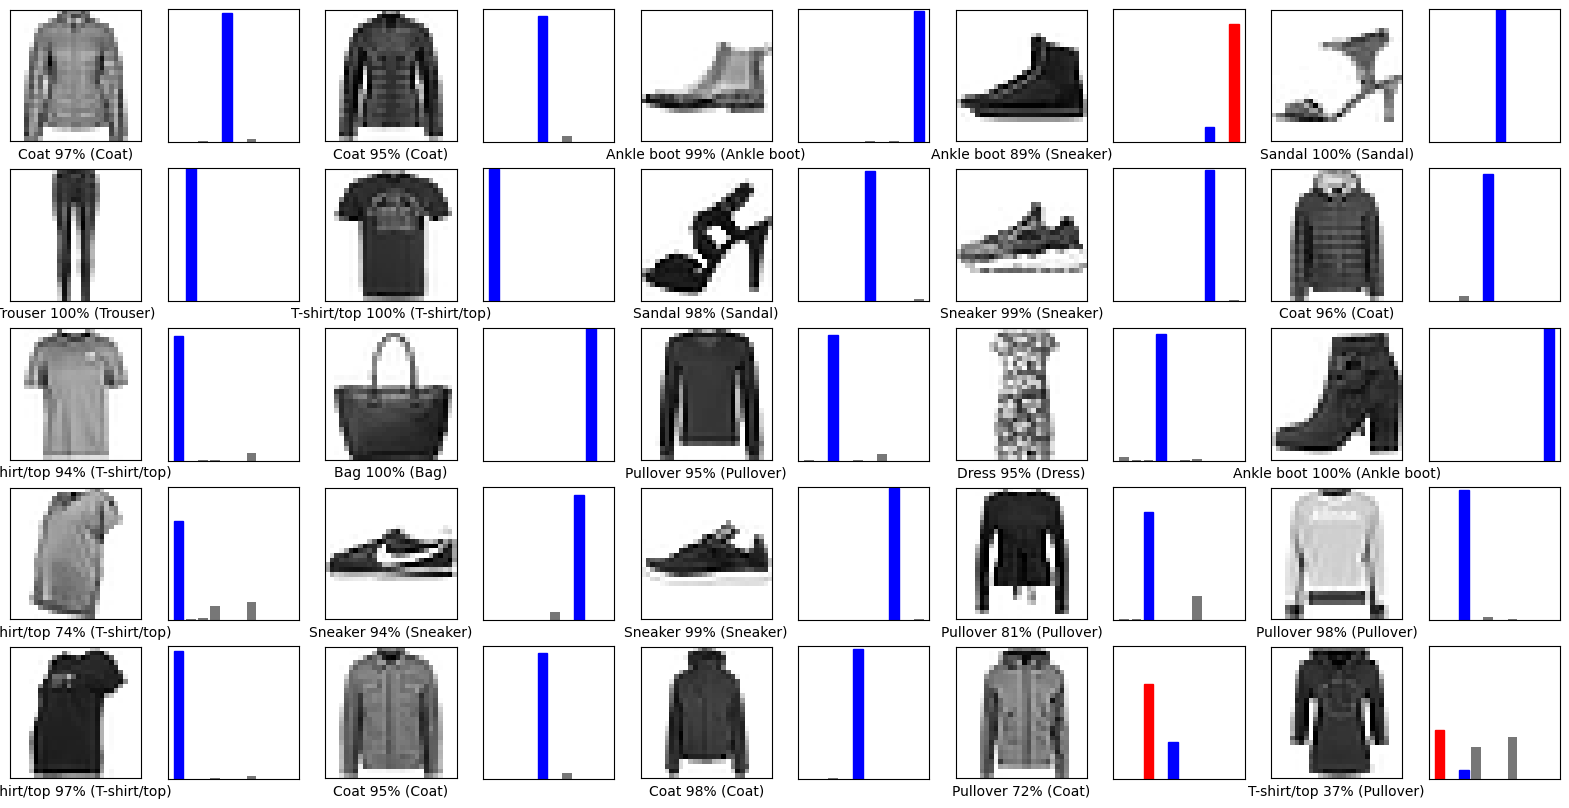

In [ ]:
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue' #Si le atino
  else:
    color = 'red'  #Oops, no le atino

  plt.xlabel("{} {:2.0f}% ({})".format(
      nombres_clases[etiqueta_prediccion],
      100*np.max(arr_predicciones),
      nombres_clases[etiqueta_real],
      color=color
  ))

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [ ]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediccion: Sandal


Uso de ImageDataGenerator

In [ ]:
#13/06/25
# Cargar y preparar los datos
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Normalizar y agregar canal
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:
# Codificar etiquetas con to_categorical
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [ ]:
# Crear el generador con aumento de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
 rotation_range=15,
 width_shift_range=0.1,
 height_shift_range=0.1,
 zoom_range=0.1
)
datagen.fit(x_train)

In [ ]:
# Visualizar imágenes aumentadas
for x_batch, y_batch in datagen.flow(x_train, y_train_cat, batch_size=9):
  break

In [ ]:
# Crear modelo CNN simple
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
 Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
 MaxPooling2D(pool_size=(2, 2)),
 Flatten(),
 Dense(64, activation='relu'),
 Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compilar y entrenar el modelo usando el generador
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(datagen.flow(x_train, y_train_cat, batch_size=32),
          epochs=5,
          validation_data=(x_test, y_test_cat))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step - accuracy: 0.6931 - loss: 0.8375 - val_accuracy: 0.8137 - val_loss: 0.4829
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 29ms/step - accuracy: 0.8007 - loss: 0.5299 - val_accuracy: 0.8323 - val_loss: 0.4550
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.8187 - loss: 0.4827 - val_accuracy: 0.8413 - val_loss: 0.4301
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.8307 - loss: 0.4515 - val_accuracy: 0.8633 - val_loss: 0.3847
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.8396 - loss: 0.4255 - val_accuracy: 0.8690 - val_loss: 0.3587


In [ ]:
# Evaluar en los datos de prueba
test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"Precisión en test: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8718 - loss: 0.3622
Precisión en test: 0.8690
